Inspiration: https://analyticsindiamag.com/guide-to-word2vec-using-skip-gram-model/

# SkipGram

In [ ]:
from nltk.corpus import gutenberg # to get bible corpus
from string import punctuation # to remove punctuation from corpus
import nltk 
import numpy as np
import re
from keras.preprocessing import text
from keras.preprocessing.sequence import skipgrams 
from keras.layers import *
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model,Sequential 

In [ ]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
bible = gutenberg.sents("bible-kjv.txt")
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc,re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc
normalize_corpus = np.vectorize(normalize_document)

In [ ]:
remove_terms

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'

In [ ]:
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_bible)
word2id = tokenizer.word_index
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id) + 1
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_bible]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:5])

Vocabulary Size: 12425
Vocabulary Sample: [('shall', 1), ('unto', 2), ('lord', 3), ('thou', 4), ('thy', 5)]


In [ ]:
# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]
# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id2word[pairs[i][0]], pairs[i][0], 
          id2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(james (1154), bible (5766)) -> 1
(bible (5766), james (1154)) -> 1
(bible (5766), quickened (4194)) -> 0
(james (1154), ephratah (4882)) -> 0
(james (1154), houghed (6015)) -> 0
(james (1154), king (13)) -> 1
(bible (5766), telah (9795)) -> 0
(king (13), bible (5766)) -> 1
(king (13), james (1154)) -> 1
(king (13), moment (2020)) -> 0


In [ ]:
skip_grams

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# build skip-gram architecture
embed_size = 100
word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size,
                        embeddings_initializer="glorot_uniform",
                        input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,
                  embeddings_initializer="glorot_uniform",
                  input_length=1))
context_model.add(Reshape((embed_size,)))

merged_output = add([word_model.output, context_model.output]) 

model_combined = Sequential()
model_combined.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
final_model = Model([word_model.input, context_model.input], model_combined(merged_output))
final_model.compile(loss="mean_squared_error", optimizer="rmsprop")
final_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_2_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 embedding_3_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 100)       1242500     ['embedding_2_input[0][0]']      
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 100)       1242500     ['embedding_3_input[0][0]']      
                                                                                            

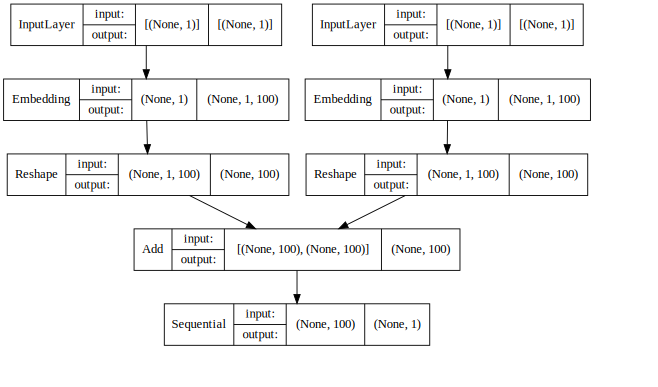

In [ ]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(final_model, show_shapes=True, show_layer_names=False, 
                rankdir='TB', dpi=65).create(prog='dot', format='svg')) 


In [ ]:
for epoch in range(1, 3):
  loss = 0
  for i, elem in enumerate(skip_grams):
      pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
      pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
      labels = np.array(elem[1], dtype='int32')
      X = [pair_first_elem, pair_second_elem]
      Y = labels
      if i % 10000 == 0:
          print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
      loss += final_model.train_on_batch(X,Y)  
  print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 3503.1118984136265
Processed 0 (skip_first, skip_second, relevance) pairs
Processed 10000 (skip_first, skip_second, relevance) pairs
Processed 20000 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 3165.7984097976005


In [ ]:
from sklearn.metrics.pairwise import euclidean_distances
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                  for search_term in ['god', 'jesus','egypt', 'john', 'famine']}
similar_words 

(12424, 12424)


{'egypt': ['trespass', 'namely', 'moses', 'hurt', 'threescore'],
 'famine': ['wafers', 'deep', 'hearted', 'waved', 'anah'],
 'god': ['land', 'said', 'house', 'unto', 'lord'],
 'jesus': ['baptized', 'diligent', 'preached', 'baptism', 'thoughts'],
 'john': ['appealed', 'fitly', 'workfellow', 'revellings', 'covetous']}

### wevi: word embedding visual inspector 
- https://ronxin.github.io/wevi/